In [1]:
%load_ext autoreload
%autoreload 2
#show plots in the notebook, formatting of the plots changes
#import ipas.lab as lab
import ipas.lab_opt_rot as lab
#import ipas.crystals_opt_rot as crys
import numpy as np
#import pickle
import time  #for efficiency tests
import itertools   #to create width array and join plate/col aspect ratios
from operator import itemgetter
import shapely.geometry as geom
import matplotlib.pyplot as plt
from descartes import PolygonPatch


Standard 100x300 plates with regular rotation/initialization

In [ ]:
import scipy.optimize as opt
import random
import numpy as np
import ipas.lab_opt_rot as lab
import ipas.crystals_opt_rot as crys

#length=10.6465986938 * 10
#width=9.6915793928 * 10

length=100
width=300
rotations= 100
plates = width > length

f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[x,0,0]).projectxy().area
xrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x
f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[0,x,0]).projectxy().area
yrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x
dim='y'
if plates:
    #dim = 'y'
    hypot = width
    rotation = [0, yrot, random.uniform(0, 2 * np.pi)]
else:
    dim = 'z'
    hypot = length
    #rotation = [0, yrot, random.uniform(0, 2 * np.pi)] #for angle from top down view
    #rotation = [np.pi/2+xrot, yrot, random.uniform(0, 2 * np.pi)]
    rotation = [np.pi/2, yrot, random.uniform(0, 2 * np.pi)]

#rotation = [0,np.pi/2,np.pi/2-1.0]
zrotseed = rotation[2]*180/np.pi
print('zrotseed',zrotseed, yrot)
seedcrystal = crys.IceCrystal(length=length, width=width, rotation=rotation)
cluster = crys.IceCluster(seedcrystal)

if plates:
    rotation = [0, yrot, random.uniform(0, 2 * np.pi)]

else:
    #rotation = [np.pi/2+xrot, yrot, random.uniform(0, 2 * np.pi)]
    rotation = [np.pi/2, yrot, random.uniform(0, 2 * np.pi)]

#rotation = [0,np.pi/2,np.pi/2+.9]
zrotnew =rotation[2]*180/np.pi
print('zrotnew',zrotnew)
new_crystal = crys.IceCrystal(length=length, width=width, rotation=rotation)
cluster.add_crystal_from_above(new_crystal)   
cluster.recenter()

height_seed = seedcrystal.maxz - seedcrystal.minz   
height_new = new_crystal.maxz - new_crystal.minz
checkposseed = False
checkposnew = False
checknegseed = False
checknegnew = False

xmaxseed = seedcrystal.max(dim)
xminseed = seedcrystal.min(dim)
pointszseed = seedcrystal.points['z']
pointsxseed = seedcrystal.points[dim]
maxzindseed = np.where(pointszseed == seedcrystal.maxz)
minzindseed = np.where(pointszseed == seedcrystal.minz)   
xatmaxzseed = max(seedcrystal.points[dim][maxzindseed])
xatminzseed = min(seedcrystal.points[dim][minzindseed])
maxxindseed = np.where(pointsxseed == xmaxseed)
minxindseed = np.where(pointsxseed == xminseed)
zatmaxxseed = max(pointszseed[maxxindseed])
zatminxseed = min(pointszseed[minxindseed])

#print('-----------------new crys-------------------')
xmaxnew = new_crystal.max(dim)
xminnew = new_crystal.min(dim)
pointsznew = new_crystal.points['z']
pointsxnew = new_crystal.points[dim]
maxzindnew = np.where(pointsznew == new_crystal.maxz)
minzindnew = np.where(pointsznew == new_crystal.minz)  
xatmaxznew = max(new_crystal.points[dim][maxzindnew])
xatminznew = min(new_crystal.points[dim][minzindnew])
maxxindnew = np.where(pointsxnew == xmaxnew) 
minxindnew = np.where(pointsxnew == xminnew) 
zatmaxxnew = max(pointsznew[maxxindnew])
zatminxnew = min(pointsznew[minxindnew])

crystals = [seedcrystal, new_crystal]
pointsxarr = [pointsxseed, pointsxnew]
slope=[]
dim = ['y','z']
hexmax = []
hexmin = []
for i in crystals:
    # make a line connecting the two hexagons at the max x value  
    #this is to determine the slope of each crystal
    hex1pts = i.points[dim][0:6]   
    hex2pts = i.points[dim][6:12]  
    hex1max = max(hex1pts[dim],key=itemgetter(0))
    hex1min = min(hex1pts[dim],key=itemgetter(0))
    hex2max = max(hex2pts[dim],key=itemgetter(0))
    hex2min = min(hex2pts[dim],key=itemgetter(0))
    
    if (hex2max['z']-hex1max['z'])/(hex2max['y']-hex1max['y'])>=0:
        slope.append('negative')
    else:
        slope.append('positive')
        
    #now determine the 'end point' of each hexagon for plates
    #for negative (positive) sloping crystals use the max 
    #(min) 'y' point of the hexagon.  If there is a point
    #beyond the max or min use that point instead for
    #'baseseed/basenew', the adjacent side of the triangle
    #for contact angle.

    if i == seedcrystal:
        pointsx = pointsxarr[0]
        
    else:
        pointsx = pointsxarr[1]

    hexmaxval = min(hex2max['y'],hex1max['y'])
    hexminval = max(hex2min['y'],hex1min['y'])
    hexmax.append(hexmaxval)
    hexmin.append(hexminval)

#----------------------------------------------------------------
#Determine what slope each crystal has and calculate the seed_ang/
#new_ang for each crystal

if slope[0] == 'negative': #neg slope
    checknegseed = True
    print('checknegseed')
    if plates:
        baseseed = hexmax[0] - xminseed
    else:
        baseseed = xatminzseed - xminseed
        
    seed_ang = np.arccos(baseseed/hypot)*(180./np.pi)          

else:
    checkposseed = True 
    print('checkposseed')
    if plates:
        baseseed = xmaxseed - hexmin[0]
    else:
        baseseed = xmaxseed - xatminzseed   
        
    seed_ang = np.arccos(baseseed/hypot)*(180./np.pi) 


if slope[1]=='negative':
    checknegnew = True
    print('checknegnew')
    if plates:
        basenew = hexmax[1] - xminnew
    else:
        basenew = xatminznew - xminnew

    new_ang = np.arccos(basenew/hypot)*(180./np.pi) 

else: #pos slope
    checkposnew = True
    print('checkposnew')
    
    if plates:
        basenew = xmaxnew - hexmin[1]
    else:
        basenew = xmaxnew - xatminznew

    new_ang = np.arccos(basenew/hypot)*(180./np.pi) 

##################################################################################    

#Check if overlap is minimal and don't subtract from 180

zmax = cluster.max('z')
zmin = cluster.min('z')
plates = width > length
height_seed = seedcrystal.maxz - seedcrystal.minz   
height_new = new_crystal.maxz - new_crystal.minz                
heightclus = zmax-zmin #0 index is x
Sz = heightclus - (heightclus - height_seed) - (heightclus - height_new)    
if plates:
    Szpercent = (Sz / heightclus)*100   
else:
    Szpercent = (Sz / heightclus)*100

print('vert_overlap', Szpercent)

#horizontal overlap
if plates:
    dim = 'y'
else:
    dim = 'z'
xmax = cluster.max(dim)
xmin = cluster.min(dim)
widclus = xmax-xmin
widseed = xmaxseed - xminseed
widnew = xmaxnew - xminnew
print(widclus, xmax, xmin)
'''
xmaxseed = seedcrystal.max('x')
xminseed = seedcrystal.min('x')
ymaxseed = seedcrystal.max('y')
yminseed = seedcrystal.min('y')
zmaxseed = seedcrystal.max('z')
zminseed = seedcrystal.min('z')
xmaxnew = new_crystal.max('x')
xminnew = new_crystal.min('x')
ymaxnew = new_crystal.max('y')
yminnew = new_crystal.min('y')
zmaxnew = new_crystal.max('z')
zminnew = new_crystal.min('z')
'''
#print(xmaxnew, xminnew, xmaxseed, xminseed)
#print(ymaxnew, yminnew, ymaxseed, yminseed)
#print(zmaxnew, zminnew, zmaxseed, zminseed)
#print(widseed, widclus-widseed, widclus-widnew)
Sx = widclus - (widclus - widseed) - (widclus - widnew)
if plates:
    Sxpercent = (Sx / widclus)*100   
else:
    Sxpercent = (Sx / widclus)*100

print('horizontal overlap', Sxpercent)

if not plates:
    new_ang = 90-new_ang
    seed_ang = 90-seed_ang

if1flag = False
cont_ang = new_ang + seed_ang
cont_ang1 = new_ang + seed_ang
print('cont_ang b4 if1', cont_ang)
if ((checkposseed == True and checkposnew == True) or (checknegseed == True and checknegnew == True)):  
    print('in if1 -- crystals slope in same direction')
    seed1_ang = 90. - seed_ang
    cont_ang = 90. - new_ang - seed1_ang
    if1flag = True
        
cont_ang = abs(cont_ang)
print('cont_ang b4 if2', cont_ang)
if cont_ang1 > 90 and Szpercent < 20.0 and cont_ang < 90:
    print('in if2')
    cont_ang = 180 - cont_ang

#---------umcomment this for different cluster views------
if plates:
    cluster.rotate_to([np.pi/2,np.pi,np.pi/2])  #view side -- z axis up down y axis left right
else:
    #cluster.rotate_to([np.pi/2,0,np.pi/2]) 
    #cluster.rotate_to([np.pi/2,np.pi,np.pi]) #angle from top down view
    #cluster.rotate_to([np.pi/2,0,0])  #view side 
    #cluster.rotate_to([0,np.pi/2,0])  #view side 
    #cluster.rotate_to([np.pi,0,np.pi/2])  #view side with xrot optimized (columns)
    #cluster.rotate_to([0,np.pi/2,0])
    cluster.rotate_to([np.pi/2,np.pi/2,np.pi/2])  #view side with z axis going left to right, y up and down

print('seed, new final',seed_ang,new_ang)
print('contact angle',cont_ang)
#cluster.rotate_to([np.pi/2,np.pi,np.pi/2])  #view side 
cluster.plot()

Plates with exact values from eq. radius output 

In [ ]:
import scipy.optimize as opt
import random
import numpy as np
import ipas.lab_opt_rot as lab
import ipas.crystals_opt_rot as crys

#length=10.6465986938 * 10
#width=9.6915793928 * 10

length=7.31047469634 * 10
width=11.6957266874 * 10
rotations= 100
plates = width > length

f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[x,0,0]).projectxy().area
xrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x
f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[0,x,0]).projectxy().area
yrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x
dim='y'
if plates:
    #dim = 'y'
    hypot = width
    rotation = [0, yrot, random.uniform(0, 2 * np.pi)]
else:
    dim = 'z'
    hypot = length
    #rotation = [0, yrot, random.uniform(0, 2 * np.pi)] #for angle from top down view
    #rotation = [np.pi/2+xrot, yrot, random.uniform(0, 2 * np.pi)]
    rotation = [np.pi/2, yrot, random.uniform(0, 2 * np.pi)]

#rotation = [0,np.pi/2,np.pi/2-1.0]
zrotseed = rotation[2]*180/np.pi
print('zrotseed',zrotseed, yrot)
seedcrystal = crys.IceCrystal(length=length, width=width, rotation=rotation)
cluster = crys.IceCluster(seedcrystal)

if plates:
    rotation = [0, yrot, random.uniform(0, 2 * np.pi)]

else:
    #rotation = [np.pi/2+xrot, yrot, random.uniform(0, 2 * np.pi)]
    rotation = [np.pi/2, yrot, random.uniform(0, 2 * np.pi)]

#rotation = [0,np.pi/2,np.pi/2+.9]
zrotnew =rotation[2]*180/np.pi
print('zrotnew',zrotnew)
new_crystal = crys.IceCrystal(length=length, width=width, rotation=rotation)
cluster.add_crystal_from_above(new_crystal)   
cluster.recenter()

height_seed = seedcrystal.maxz - seedcrystal.minz   
height_new = new_crystal.maxz - new_crystal.minz
checkposseed = False
checkposnew = False
checknegseed = False
checknegnew = False

xmaxseed = seedcrystal.max(dim)
xminseed = seedcrystal.min(dim)
pointszseed = seedcrystal.points['z']
pointsxseed = seedcrystal.points[dim]
maxzindseed = np.where(pointszseed == seedcrystal.maxz)
minzindseed = np.where(pointszseed == seedcrystal.minz)   
xatmaxzseed = max(seedcrystal.points[dim][maxzindseed])
xatminzseed = min(seedcrystal.points[dim][minzindseed])
maxxindseed = np.where(pointsxseed == xmaxseed)
minxindseed = np.where(pointsxseed == xminseed)
zatmaxxseed = max(pointszseed[maxxindseed])
zatminxseed = min(pointszseed[minxindseed])

#print('-----------------new crys-------------------')
xmaxnew = new_crystal.max(dim)
xminnew = new_crystal.min(dim)
pointsznew = new_crystal.points['z']
pointsxnew = new_crystal.points[dim]
maxzindnew = np.where(pointsznew == new_crystal.maxz)
minzindnew = np.where(pointsznew == new_crystal.minz)  
xatmaxznew = max(new_crystal.points[dim][maxzindnew])
xatminznew = min(new_crystal.points[dim][minzindnew])
maxxindnew = np.where(pointsxnew == xmaxnew) 
minxindnew = np.where(pointsxnew == xminnew) 
zatmaxxnew = max(pointsznew[maxxindnew])
zatminxnew = min(pointsznew[minxindnew])

crystals = [seedcrystal, new_crystal]
pointsxarr = [pointsxseed, pointsxnew]
slope=[]
dim = ['y','z']
hexmax = []
hexmin = []
for i in crystals:
    # make a line connecting the two hexagons at the max x value  
    #this is to determine the slope of each crystal
    hex1pts = i.points[dim][0:6]   
    hex2pts = i.points[dim][6:12]  
    hex1max = max(hex1pts[dim],key=itemgetter(0))
    hex1min = min(hex1pts[dim],key=itemgetter(0))
    hex2max = max(hex2pts[dim],key=itemgetter(0))
    hex2min = min(hex2pts[dim],key=itemgetter(0))
    
    if (hex2max['z']-hex1max['z'])/(hex2max['y']-hex1max['y'])>=0:
        slope.append('negative')
    else:
        slope.append('positive')
        
    #now determine the 'end point' of each hexagon for plates
    #for negative (positive) sloping crystals use the max 
    #(min) 'y' point of the hexagon.  If there is a point
    #beyond the max or min use that point instead for
    #'baseseed/basenew', the adjacent side of the triangle
    #for contact angle.

    if i == seedcrystal:
        pointsx = pointsxarr[0]
        
    else:
        pointsx = pointsxarr[1]

    hexmaxval = min(hex2max['y'],hex1max['y'])
    hexminval = max(hex2min['y'],hex1min['y'])
    hexmax.append(hexmaxval)
    hexmin.append(hexminval)

#----------------------------------------------------------------
#Determine what slope each crystal has and calculate the seed_ang/
#new_ang for each crystal

if slope[0] == 'negative': #neg slope
    checknegseed = True
    print('checknegseed')
    if plates:
        baseseed = hexmax[0] - xminseed
    else:
        baseseed = xatminzseed - xminseed
        
    seed_ang = np.arccos(baseseed/hypot)*(180./np.pi)          

else:
    checkposseed = True 
    print('checkposseed')
    if plates:
        baseseed = xmaxseed - hexmin[0]
    else:
        baseseed = xmaxseed - xatminzseed   
        
    seed_ang = np.arccos(baseseed/hypot)*(180./np.pi) 


if slope[1]=='negative':
    checknegnew = True
    print('checknegnew')
    if plates:
        basenew = hexmax[1] - xminnew
    else:
        basenew = xatminznew - xminnew

    new_ang = np.arccos(basenew/hypot)*(180./np.pi) 

else: #pos slope
    #if xmaxnew-xatmaxznew < xatmaxznew-xminnew:    
    #get point between xmin and xatzmin for when plate crystal 
    #is flat and z min is not at the far end/point of the crystal
    checkposnew = True
    print('checkposnew')
    #xbetwn = pointsxnew[np.argsort(np.abs(pointsxnew-xminnew))[1]]
    #zatxbetwnind = np.where(pointsxnew == xbetwn)
    #zatxbetwn = min(pointsznew[zatxbetwnind])   
    #zflag = any(i <= zatxbetwn for i in pointsznew) 
    
    #if there is any point below zatxbetwn for neg slope 
    #the base of the triangle (adj side) goes from xmax to 
    #the point along the base of the crystal just to the right
    #of xminnew
    #if plates and zflag:# and zatmaxxnew<zatminxnew:
    #    basenew = xmaxnew - xbetwn
    #    print('new xbetwn')
    if plates:
        basenew = xmaxnew - hexmin[1]
    else:
        basenew = xmaxnew - xatminznew

    new_ang = np.arccos(basenew/hypot)*(180./np.pi) 

##################################################################################    

#Check if overlap is minimal and don't subtract from 180

zmax = cluster.max('z')
zmin = cluster.min('z')
plates = width > length
height_seed = seedcrystal.maxz - seedcrystal.minz   
height_new = new_crystal.maxz - new_crystal.minz                
heightclus = zmax-zmin #0 index is x
Sz = heightclus - (heightclus - height_seed) - (heightclus - height_new)    
if plates:
    Szpercent = (Sz / heightclus)*100   
else:
    Szpercent = (Sz / heightclus)*100

print('vert_overlap', Szpercent)

#horizontal overlap
if plates:
    dim = 'y'
else:
    dim = 'z'
xmax = cluster.max(dim)
xmin = cluster.min(dim)
widclus = xmax-xmin
widseed = xmaxseed - xminseed
widnew = xmaxnew - xminnew
#print(widclus, xmax, xmin)
'''
xmaxseed = seedcrystal.max('x')
xminseed = seedcrystal.min('x')
ymaxseed = seedcrystal.max('y')
yminseed = seedcrystal.min('y')
zmaxseed = seedcrystal.max('z')
zminseed = seedcrystal.min('z')
xmaxnew = new_crystal.max('x')
xminnew = new_crystal.min('x')
ymaxnew = new_crystal.max('y')
yminnew = new_crystal.min('y')
zmaxnew = new_crystal.max('z')
zminnew = new_crystal.min('z')
'''
#print(xmaxnew, xminnew, xmaxseed, xminseed)
#print(ymaxnew, yminnew, ymaxseed, yminseed)
#print(zmaxnew, zminnew, zmaxseed, zminseed)
#print(widseed, widclus-widseed, widclus-widnew)
Sx = widclus - (widclus - widseed) - (widclus - widnew)
if plates:
    Sxpercent = (Sx / widclus)*100   
else:
    Sxpercent = (Sx / widclus)*100

print('horizontal overlap', Sxpercent)

if not plates:
    new_ang = 90-new_ang
    seed_ang = 90-seed_ang

if1flag = False
cont_ang = new_ang + seed_ang
cont_ang1 = new_ang + seed_ang
print('cont_ang b4 if1', cont_ang)
if ((checkposseed == True and checkposnew == True) or (checknegseed == True and checknegnew == True)):  
    print('in if1 -- crystals slope in same direction')
    seed1_ang = 90. - seed_ang
    cont_ang = 90. - new_ang - seed1_ang
    if1flag = True
        
cont_ang = abs(cont_ang)
print('cont_ang b4 if2', cont_ang)
if cont_ang1 > 90 and Szpercent < 20.0 and cont_ang < 90:# and Sxpercent < 40.0 and if1flag == True:
    print('in if2')
    cont_ang = 180 - cont_ang

#---------umcomment this for different cluster views------
if plates:
    cluster.rotate_to([np.pi/2,np.pi,np.pi/2])  #view side -- z axis up down y axis left right
else:
    #cluster.rotate_to([np.pi/2,0,np.pi/2]) 
    #cluster.rotate_to([np.pi/2,np.pi,np.pi]) #angle from top down view
    #cluster.rotate_to([np.pi/2,0,0])  #view side 
    #cluster.rotate_to([0,np.pi/2,0])  #view side 
    #cluster.rotate_to([np.pi,0,np.pi/2])  #view side with xrot optimized (columns)
    #cluster.rotate_to([0,np.pi/2,0])
    cluster.rotate_to([np.pi/2,np.pi/2,np.pi/2])  #view side with z axis going left to right, y up and down

print('seed, new final',seed_ang,new_ang)
print('contact angle',cont_ang)
#cluster.rotate_to([np.pi/2,np.pi,np.pi/2])  #view side 
cluster.plot() 

Dimension arrays added

checkposseed
baseseed pos 135.595081208
hexmax, xatminzseed -70.6167243434 -64.9783568647
checkposnew
vert_overlap 80.8314931984
horizontal overlap 1.08744940476
cont_ang b4 if1 45.6444219126
in if1 -- crystals slope in same direction
cont_ang b4 if2 30.4868232719
seed, new final 7.57879932035 38.0656225922
contact angle 30.4868232719


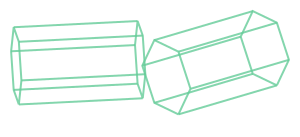

In [7]:
import scipy.optimize as opt
import random
import numpy as np
import ipas.lab_opt_rot as lab
import ipas.crystals_opt_rot as crys


length=13.6790022746 * 10
width=8.55013140036 * 10

#length=100
#width=300
rotations= 100
plates = width > length

f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[x,0,0]).projectxy().area
xrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x
f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[0,x,0]).projectxy().area
yrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x

if plates:
    dim = 'y'
    dim_up = 'z'
    dimarr = ['y','z']
    dimindup = 1
    dimind = 0
    hypot = width
    rotation = [0, yrot, random.uniform(0, 2 * np.pi)]
else:
    dim = 'z'
    dim_up = 'y'
    dimarr = ['z','y']
    dimindup = 1
    dimind = 0
    hypot = length
    #rotation = [0, yrot, random.uniform(0, 2 * np.pi)] #for angle from top down view
    #rotation = [np.pi/2+xrot, yrot, random.uniform(0, 2 * np.pi)]
    rotation = [np.pi/2, yrot, random.uniform(0, 2 * np.pi)]
#print('yrot',yrot)
#rotation = [0,np.pi/2,np.pi/2-1.0]
zrotseed = rotation[2]*180/np.pi
#print('zrotseed',zrotseed)

seedcrystal = crys.IceCrystal(length=length, width=width, rotation=rotation)
cluster = crys.IceCluster(seedcrystal)

if plates:
    rotation = [0, yrot, random.uniform(0, 2 * np.pi)]

else:
    #rotation = [np.pi/2+xrot, yrot, random.uniform(0, 2 * np.pi)]
    rotation = [np.pi/2, yrot, random.uniform(0, 2 * np.pi)]

#rotation = [0,np.pi/2,np.pi/2+.9]
zrotnew =rotation[2]*180/np.pi
#print('zrotnew',zrotnew)
new_crystal = crys.IceCrystal(length=length, width=width, rotation=rotation)
crystal_hit = cluster.add_crystal_from_above(new_crystal)   

if crystal_hit:
    cluster.recenter()

    height_seed = seedcrystal.maxz - seedcrystal.minz   
    height_new = new_crystal.maxz - new_crystal.minz
    checkposseed = False
    checkposnew = False
    checknegseed = False
    checknegnew = False

    xmaxseed = seedcrystal.max(dim)
    xminseed = seedcrystal.min(dim)
    pointszseed = seedcrystal.points[dim_up]
    pointsxseed = seedcrystal.points[dim]
    maxzindseed = np.where(pointszseed == seedcrystal.max(dim_up))
    minzindseed = np.where(pointszseed == seedcrystal.min(dim_up))
    xatmaxzseed = max(seedcrystal.points[dim][maxzindseed])
    xatminzseed = min(seedcrystal.points[dim][minzindseed])
    maxxindseed = np.where(pointsxseed == xmaxseed)
    minxindseed = np.where(pointsxseed == xminseed)
    zatmaxxseed = max(pointszseed[maxxindseed])
    zatminxseed = min(pointszseed[minxindseed])

    #print('-----------------new crys-------------------')
    xmaxnew = new_crystal.max(dim)
    xminnew = new_crystal.min(dim)
    pointsznew = new_crystal.points[dim_up]
    pointsxnew = new_crystal.points[dim]
    maxzindnew = np.where(pointsznew == new_crystal.max(dim_up))
    minzindnew = np.where(pointsznew == new_crystal.min(dim_up))
    xatmaxznew = max(new_crystal.points[dim][maxzindnew])
    xatminznew = min(new_crystal.points[dim][minzindnew])
    maxxindnew = np.where(pointsxnew == xmaxnew) 
    minxindnew = np.where(pointsxnew == xminnew) 
    zatmaxxnew = max(pointsznew[maxxindnew])
    zatminxnew = min(pointsznew[minxindnew])

    
    crystals = [seedcrystal, new_crystal]
#    pointsxarr = [pointsxseed, pointsxnew]
    slope=[]
    #dimarr = ['y','z']
    hexmax = []
    hexmin = []
    
    #fig = plt.figure(1, figsize=(5,5))
    #ax = fig.add_subplot(111)

    for i in crystals:
        # make a line connecting the two hexagons at the max x value  
        #this is to determine the slope of each crystal
        hex1pts = i.points[dimarr][0:6]  
        hex2pts = i.points[dimarr][6:12]  
        
        poly1 = geom.Polygon([[p[0], p[1]] for p in hex1pts])       
        poly2 = geom.Polygon([[p[0], p[1]] for p in hex2pts])
        
        #add patches here
        
        hex1max = max(hex1pts[dimarr],key=itemgetter(dimindup))
        hex1min = min(hex1pts[dimarr],key=itemgetter(dimindup))
        #print('hex1min',hex1min)
        #print('hex2pts',hex2pts)
        hex2max = max(hex2pts[dimarr],key=itemgetter(dimindup))
        hex2min = min(hex2pts[dimarr],key=itemgetter(dimindup))
        #print('hex2min',hex2min)
        
        #Plates: when the lines connecting the hexagons slope positive the crystal slopes negative
        #Columns: when the lines connecting the hexagons slope positive the crystal also slopes positive 
        if (hex2max[dimarr[dimindup]]-hex1max[dimarr[dimindup]])/(hex2max[dimarr[dimind]]-hex1max[dimarr[dimind]])>=0:
            if plates:
                slope.append('negative')
            else:
                slope.append('positive')
        else:
            if plates:
                slope.append('positive')
            else:
                slope.append('negative')

#        if i == seedcrystal:
#            pointsx = pointsxarr[0]

#        else:
#            pointsx = pointsxarr[1]

        #hexmaxval = min(hex2max[dimarr[dimind]],hex1max[dimarr[dimind]])
        hexminval = max(hex1min,hex2min,key=itemgetter(dimindup))
        #hexminval = max(hex2min[dimarr[dimind]],hex1min[dimarr[dimind]])
        hexmaxval = min(hex1max,hex2max,key=itemgetter(dimindup))
        
        hexmax.append(hexmaxval[dimarr[dimind]])
        hexmin.append(hexminval[dimarr[dimind]])
    #----------------------------------------------------------------
    #Determine what slope each crystal has and calculate the seed_ang/
    #new_ang for each crystal
    if slope[0] == 'negative': #neg slope
        checknegseed = True
        print('checknegseed')
        if plates:
            baseseed = hexmax[0] - xminseed
        else:
            baseseed = xatminzseed - hexmin[0]
        print('baseseed neg', baseseed)
        print('xatminzseed, hexmin[0]', xatminzseed,hexmin[0])
        print('hexmin[0], hexmax[0]',hexmin[0], hexmax[0])
        seed_ang = np.arccos(baseseed/hypot)*(180./np.pi)          

    else:
        checkposseed = True 
        print('checkposseed')
        if plates:
            baseseed = xmaxseed - hexmin[0]
        else:
            baseseed = hexmin[0] - xatminzseed   
        print('baseseed pos',baseseed)
        print('hexmax, xatminzseed',hexmax[0], xatminzseed)
        seed_ang = np.arccos(baseseed/hypot)*(180./np.pi) 


    if slope[1]=='negative':
        checknegnew = True
        print('checknegnew')
        if plates:
            basenew = hexmax[1] - xminnew
        else:
            basenew = xatminznew - hexmin[1]
        print('base',basenew, hypot)
        print('hexmin, xatminznew',hexmin[1], xatminznew)
        new_ang = np.arccos(basenew/hypot)*(180./np.pi) 

    else: #pos slope
        #if xmaxnew-xatmaxznew < xatmaxznew-xminnew:    
        #get point between xmin and xatzmin for when plate crystal 
        #is flat and z min is not at the far end/point of the crystal
        checkposnew = True
        print('checkposnew')
        #xbetwn = pointsxnew[np.argsort(np.abs(pointsxnew-xminnew))[1]]
        #zatxbetwnind = np.where(pointsxnew == xbetwn)
        #zatxbetwn = min(pointsznew[zatxbetwnind])   
        #zflag = any(i <= zatxbetwn for i in pointsznew) 

        #if there is any point below zatxbetwn for neg slope 
        #the base of the triangle (adj side) goes from xmax to 
        #the point along the base of the crystal just to the right
        #of xminnew
        #if plates and zflag:# and zatmaxxnew<zatminxnew:
        #    basenew = xmaxnew - xbetwn
        #    print('new xbetwn')
        if plates:
            basenew = xmaxnew - hexmin[1]
        else:
            basenew = hexmin[1] - xatminznew
        #print('base, hypot',basenew, hypot)
        #print('hexmin, xatminznew',hexmin[1], xatminznew)
        
        
        new_ang = np.arccos(basenew/hypot)*(180./np.pi) 
        #print('hexmax, xatminzseed',hexmax[0], xatminzseed)
    #print('xatminznew',xatminznew, xatminzseed)
    #print('xmaxseed,new',xmaxseed, xmaxnew)
    ##################################################################################    

    #Check if overlap is minimal and don't subtract from 180

    zmax = cluster.max('y')
    zmin = cluster.min('y')
    plates = width > length
    height_seed = seedcrystal.max('y') - seedcrystal.min('y')   
    height_new = new_crystal.max('y') - new_crystal.min('y')              
    heightclus = zmax-zmin #0 index is x
    Sz = heightclus - (heightclus - height_seed) - (heightclus - height_new)    
    if plates:
        Szpercent = (Sz / heightclus)*100   
    else:
        Szpercent = (Sz / heightclus)*100

    print('vert_overlap', Szpercent)

    #horizontal overlap
    xmax = cluster.max(dimarr[dimind])
    xmin = cluster.min(dimarr[dimind])
    widclus = xmax-xmin
    widseed = xmaxseed - xminseed
    widnew = xmaxnew - xminnew
    #print(widclus, xmax, xmin)
    '''
    xmaxseed = seedcrystal.max('x')
    xminseed = seedcrystal.min('x')
    ymaxseed = seedcrystal.max('y')
    yminseed = seedcrystal.min('y')
    zmaxseed = seedcrystal.max('z')
    zminseed = seedcrystal.min('z')
    xmaxnew = new_crystal.max('x')
    xminnew = new_crystal.min('x')
    ymaxnew = new_crystal.max('y')
    yminnew = new_crystal.min('y')
    zmaxnew = new_crystal.max('z')
    zminnew = new_crystal.min('z')
    '''
    #print(xmaxnew, xminnew, xmaxseed, xminseed)
    #print(ymaxnew, yminnew, ymaxseed, yminseed)
    #print(zmaxnew, zminnew, zmaxseed, zminseed)
    #print(widseed, widclus-widseed, widclus-widnew)

    Sx = widclus - (widclus - widseed) - (widclus - widnew)
    if plates:
        Sxpercent = (Sx / widclus)*100   
    else:
        Sxpercent = (Sx / widclus)*100

    print('horizontal overlap', Sxpercent)

    #if not plates:
        #new_ang = 90-new_ang
        #seed_ang = 90-seed_ang

    cont_ang = new_ang + seed_ang
    cont_ang1 = new_ang + seed_ang
    print('cont_ang b4 if1', cont_ang)
    if ((checkposseed == True and checkposnew == True) or (checknegseed == True and checknegnew == True)):  
        print('in if1 -- crystals slope in same direction')
        seed1_ang = 90. - seed_ang
        cont_ang = 90. - new_ang - seed1_ang
        if1flag = True

    cont_ang = abs(cont_ang)
    print('cont_ang b4 if2', cont_ang)
    if cont_ang1 > 90 and Sxpercent > 20.0 and cont_ang < 90:
        print('in if2')
        cont_ang = 180 - cont_ang

    #---------umcomment this for different cluster views------
    if plates:
        cluster.rotate_to([np.pi/2,np.pi,np.pi/2])  #view side -- z axis up down y axis left right
    else:
        #cluster.rotate_to([np.pi/2,0,np.pi/2]) 
        #cluster.rotate_to([np.pi/2,np.pi,np.pi]) #angle from top down view
        #cluster.rotate_to([np.pi/2,0,0])  #view side 
        #cluster.rotate_to([0,np.pi/2,0])  #view side 
        #cluster.rotate_to([np.pi,0,np.pi/2])  #view side with xrot optimized (columns)
        #cluster.rotate_to([0,np.pi/2,0])
        cluster.rotate_to([np.pi/2,np.pi/2,-np.pi/2])  #view side with z axis going left to right

    print('seed, new final',seed_ang,new_ang)
    print('contact angle',cont_ang)
    #cluster.rotate_to([np.pi/2,np.pi,np.pi/2])  #view side 
cluster.plot()


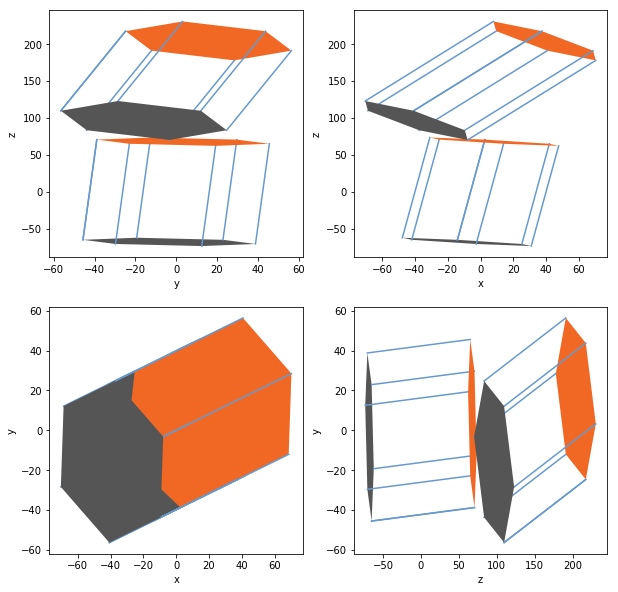

In [8]:
crystals = [seedcrystal, new_crystal]
dims = [['y','z'],['x','z'],['x','y'],['z','y']]
in_out = ['x','y','z','x']
fig, ax = plt.subplots(2,2, figsize=(10, 10), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.3)
ax = ax.ravel()
for l in range(len(dims)):
    for i in crystals:    
        hex1pts = i.points[dims[l]][0:6]
        poly1 = geom.Polygon([[p[0], p[1]] for p in hex1pts])
        hex2pts = i.points[dims[l]][6:12]
        poly2 = geom.Polygon([[p[0], p[1]] for p in hex2pts])

        x1,y1 = poly1.exterior.xy
        x2,y2 = poly2.exterior.xy
        if max(i.points[in_out[l]][0:6]) > max(i.points[in_out[l]][6:12]):
            if i == seedcrystal:
                color1='#f16825'
                zorder1 = 2
                color2 = '#555555'
                zorder2 = 0
                zorder = 1
            else:
                color1='#f16825'
                zorder1 = 5
                color2 = '#555555'
                zorder2 = 3
                zorder = 4
        else:
            if i == seedcrystal:
                color1='#555555'
                zorder1 = 0
                color2='#f16825'
                zorder2 = 2
                zorder = 1
            else:
                color1 = '#555555'              
                zorder1 = 5
                color2='#f16825'
                zorder2 = 3
                zorder = 4
                
        for n in range(7):
            x = [x1[n],x2[n]]
            y = [y1[n],y2[n]]
            ax[l].plot(x,y,color='#6699cc',zorder=zorder)
            
        
        polypatch1 = PolygonPatch(poly1, fill=True, ec='none', fc=color1, zorder=zorder1)     
        polypatch2 = PolygonPatch(poly2, fill=True, ec='none', fc=color2, zorder=zorder2)
        #ax[l].plot(x1,y1, zorder=zorder1, color='#6699cc') #edges of polygons
        #ax[l].plot(x2,y2, zorder=zorder2, color='#6699cc') 
        ax[l].add_patch(polypatch1)
        ax[l].add_patch(polypatch2)
    ax[l].set_xlabel(dims[l][0])
    ax[l].set_ylabel(dims[l][1])
         

plt.show()